# Depolarization of echo chambers by a random dynamical nudge

To study the effect of RDN, we use an opinion dynamics model.
For a system of $N$ agents, each agent $i$ has an evolving opinion $x_i(t) \in [-\infty, \infty]$.
For a given issue, agent $i$ has a stance with sign $\sigma(x_i)$ and a conviction with strength $|x_i|$.
Strong convictions correspond to one of two extremes.
Agent opinions change based on their interactions with other agents $A_{ij}(t)$,
the strength of social interactions $K > 0$, and the controversialness of the issue $\alpha > 0$
as in Ref \cite{baumann2020modeling}. The opinion dynamics is given by

$$\dot{x}_i= -x_i + K \left(\sum^{N}_{j=1} A_{ij} (t)  \tanh{(\alpha x_j)}\right) + D \sqrt {n}\left({\bar{X}}_{n}-\langle x \rangle \right) \tag{1}$$

Where $D$ is the RDN strength, $\bar{X}_{n}$ is the mean from a sample (of size $n << N$) of opinions,
and $\langle x \rangle$ is the true mean of all opinions.

## Imports and settings

If in a Colab notebook, this will
1. mount your Google Drive (by asking for an authorization code)
1. pull the latest version of ``opinion_dynamics`` from GitHub
1. add ``opinion_dynamics`` to path
1. install/upgrade packages
    - upgrade ``tqdm`` for ``tenumerate`` function
    - upgrade ``tables`` for appending to `hdf5` files without throwing an error.
    - ``vaex`` for large file reading without crashing the session
        - upgrade ``IPython`` for ``vaex`` [see #514](https://github.com/vaexio/vaex/issues/514) (upgrading seems to make colab unhappy and won't display Jupyter widgets).
1. make `.cache` and `.output` in your Google Drive under `My Drive > Colab Notebooks > opdynamics`
1. create symlinks between Colab's temporary local `.cache` and `.output` and the Google Drive folders for persistence

> Note:
> 1. After installing packages you **must** restart runtime.
> 1. Creating symlinks will fail when running the cell again. This is expected.

In [ ]:
#@title Colab Setup { display-mode: "form" }
try:
    # connect GDrive for retrieving/saving results
    from google.colab import drive
    drive.mount('/content/drive')

    # Clone github repository
    from os.path import join  
    GIT_USERNAME = "chriscurrin"
    # TODO: remove this from github before publishing
    GIT_TOKEN = "bbf24b4521d81a3893d6c93eb806d41b47322a33"  
    GIT_REPOSITORY = "opinion_dynamics" 
    GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
    !rm -rf ./temp
    !git clone --quiet "{GIT_PATH}" ./temp

    # add to path
    import sys
    sys.path.append('./temp')
    # need latest tqdm version for tenumerate and tables to prevent HDF read error
    !pip install -q --upgrade tqdm tables
    !pip install -q --upgrade vaex IPython
    # create symlink between a Drive folder and the cache for persistence between sessions
    import os
    try:
        os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/.cache")
        os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/output")
    except IOError:
        pass
    !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/.cache" ".cache"
    !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/output" "output"
except ModuleNotFoundError:
    print("local notebook")
    pass

In [ ]:
#@title Imports and settings { display-mode: "form" }
%reload_ext autoreload
%autoreload 2

import logging
import itertools
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
from matplotlib.cbook import flatten

try:
    import opdynamics.simulation as Simulation
except AttributeError:
    raise RuntimeError("restart runtime")
from opdynamics.networks.echochamber import (EchoChamber, ConnChamber, ContrastChamber, OpenChamber, SampleChamber,
                                             logger as eclogger,
                                             )
from opdynamics.visualise import (VisEchoChamber,
                                  show_K_alpha_phase,
                                  show_activity_vs_opinion,
                                  show_jointplot,
                                  show_noise_panel,
                                  show_opinion_grid,
                                  )
from opdynamics.metrics.opinions import calc_distribution_differences
from opdynamics.visualise import plot_surface_product, plot_surfaces
from opdynamics.utils.distributions import negpowerlaw
from opdynamics.utils.plot_utils import df_multi_mask, move_cbar_label_to_title
from opdynamics.utils.constants import *

try:
    os.makedirs("output")
except FileExistsError:
    pass
try:
    os.makedirs(".cache")
except FileExistsError:
    pass

np.random.seed(1337)
sns.set(context="notebook", style="ticks",
        rc={
            "figure.facecolor":"white",
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.right": False,
            "axes.spines.top": False,
            }
        )
logging.basicConfig(level=logging.DEBUG)
logging.getLogger().setLevel(logging.DEBUG)
eclogger.setLevel(logging.DEBUG)
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("asyncio").setLevel(logging.WARNING)

# EchoChambers

We start by showing the rich *object orientated programming* (OOP) approach to building and running a network that produces echo chambers.

Later, we show how to use `simulation`, which encapsulates a lot of the OOP concepts into a more *functional* approach.

## Define parameters

 Symbol     | Variable | Keyword      | Meaning                                   | Range ($\mathbb{R}$)
------------|----------|--------------|-------------------------------------------|---------------------
 N          | N        | ``N``        | Number of agents                          | $>=1$
 m          | m        | ``m``        | Number of other agents to interact with   | $[1,N)$
 $\alpha$   | α        | ``alpha``    | controversialness of issue                | $>0$
 $K$        | K        | ``K``        | social interaction strength               | $>0$
 $\epsilon$ | ε        | ``epsilon``  | minimum activity level with another agent | $>0$
 $\gamma$   | Υ        | ``gamma``    | power law decay of activity distribution  | $[-\infty, \infty]$
 $\beta$    | β        | ``beta``     | power law decay of connection probability | $[-\infty, \infty]$
 $r$        | r        | ``r``        | probability of a mutual interaction       | $[0,1]$ 
 

In [ ]:
N = 1000
m = 10
alpha = 3
K = 3
epsilon = 1e-2
gamma = 2.1
beta = 3
r = 0.5
# set default activity distribution
activity_distribution = negpowerlaw

## Create EchoChamber object

An associated `VisEchoChamber` object is created for quick visualisations.

ec = EchoChamber(N, m, K, alpha)
vis = VisEchoChamber(ec)

## Set activity based on powerlaw distribution

$$F(a) = (\gamma-1) \varepsilon^{\gamma-1} a^{-\gamma} \tag{2}$$

#@title Show activities for one network { display-mode: "form" }

ec.set_activities(activity_distribution, gamma, epsilon)
fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.subplots_adjust(wspace=0.3)
fig.suptitle("t=0")
vis.show_activities(ax=ax[0])
vis.show_activity_vs_opinion(ax=ax[1])

In [5]:
## Social Interactions

$A_{ij}(t)$ is the temporal adjacency matrix, which represents the temporal variability
of interactions \cite{barabasi2005origin}, with $A_{ij}(t)=1$ when there is an input
from agent $j$ to $i$ and $A_{ij}(t)=0$ otherwise. The probabilistic reciprocity
factor $r \in [0, 1]$ determines the chance that a connection is mutually influential,
$(A_{ij}(t)=A_{ji}(t)=1)$. If the interaction is reciprocated, both agents update
their opinions; otherwise, only one of the agents' opinions is updated. For each
instance of the adjacency matrix, interactions are governed by each agent's activity
$a_i \in [\varepsilon, 1]$, the propensity for agent $i$ to interact with $m$ other agents,
and the probability $p_{ij}$ that an active agent $i$ will connect with another agent $j$.
This can lead to the polarization of opinions, where most agents hold a moderate stance on
a binary issue and few, if any, agents have a neutral opinion (Fig. 1(a)).
If active agents have an equal chance of interacting with $m$ other agents regardless of
their stance, then the network can become radicalized, with all agents having the same
stance (Fig. 1(b)).

> a note on implementation
>
> the class `SocialInteraction` (in `opdynamics.dynamics.socialinteraction.py`) handles these dynamics.
>
> it handles calling `get_connection_probabilities` and `get_social_interaction` at each `dt`.
>
> for convenience, arguments for the class and methods are handle by `EchoChamber.set_social_interactions(beta, r, **kwargs)`.
> This (more or less) calls `SocialInteraction(**kwargs)` and `get_connection_probabilities(beta, **kwargs)` and `get_social_interaction(r)`

### connection probabilities

We define the connection probabilities as a function of the magnitude between two agents' opinions:

$$ p_{ij} = \frac{|x_i - x_j|^{-\beta}}{\sum_j |x_i - x_j|^{-\beta}} \tag{3}$$

Where $\beta$ is the homophily factor, the tendency for agents with similar opinions to interact with each other:
$\beta = 0$ refers to no interaction preference, and $\beta > 0$ means agents with similar opinions are more likely to interact.
Eq. \ref{conn.eq} is modeled as a power-law decay of connection probabilities with only a small chance for agents with opposite
opinions to interact. Due to most interactions occurring between agents with similar opinions, this can lead to the formation of
echo chambers (Fig. \ref{od1.fig}(d)). We instantiate $p_{ij}$ based on the initial uniform distribution of
opinions $x_i \sim \mathcal{U}(0,1)$ \cite{baumann2020modeling}.

These results held whether the temporal network $A_{ij}(t)$ was determined by an initial $p_{ij}$ or one that was
determined at every time point $p_{ij}(t)$ (`ec.set_social_interactions(beta, r, update_conn=True)`).

### mutual interactions

Every interaction from $j$ to $i$ has a chance $r$ of being reciprocal/mutual. That is, $r=0$ means a directed graph of
interactions, one-way influence, and $r=1$ means an undirected graph of connections and a symmetrical adjacency matrix.

- The matrices are computed either
    - before the network is run (`run_network`) using `lazy=False` (*warning: can use a lot of RAM!*)
    - on demand using `lazy=True`.
- Cumulative adjacency matrix $\sum_{t=0}^T A_{ij}(t)$ can be plotted a number of ways using `vis.show_adjacency_matrix(...)`
    - `clustermap`
    - `heatmap`
    - `mesh`
    
    Interactions can be sorted using `sort=True` for plotting to identify clusters

SyntaxError: invalid syntax (<ipython-input-5-fe2234022b37>, line 3)

In [ ]:
#@title Set social interactions and show connection probabilities

ec.set_social_interactions(beta, r, lazy=False, t_end=5, dt=0.01)

fig, ax = vis.show_connection_probabilities("mesh", sort=True,
                                  cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                                  cbar_kws=dict(pad=0.05))
# move label to title
move_cbar_label_to_title(fig)
plt.show()
vis.show_adjacency_matrix("mesh", True)

In [ ]:
# other examples
vis.show_adjacency_matrix("clustermap", ax=False, fig=False, sort=False)
vis.show_adjacency_matrix("heatmap", sort=True, square=True)


DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 501 adjacency matrices...
501it [00:14, 33.44it/s]
DEBUG:social interaction:adjacency matrix has shape = (501, 1000, 1000)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x239492b2d08>)

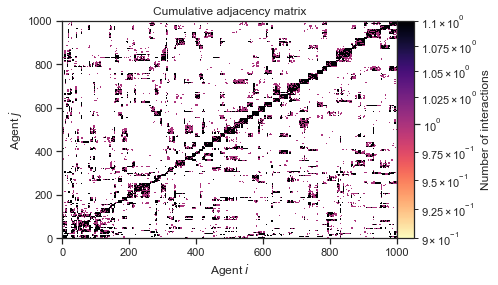

In [7]:
## Opinion dynamics (without RDN)

ec.set_dynamics()

In [8]:
## Run and plot results

dt = 0.01
T = 0.5
ec.run_network(dt=dt, t_end=T, method='Euler')

# some options on how to plot
fig, ax = plt.subplots(nrows=3, sharex='col', sharey='col', figsize=(6,6))
fig.subplots_adjust(hspace=0.05)
vis.show_opinions(color_code=True, ax=ax[0], title=True)     # markers
vis.show_opinions(color_code='line', ax=ax[1], title=False)  # lines
vis.show_opinions(color_code=False, ax=ax[2], title=False)   # agents uniquely coloured
sns.despine(fig)

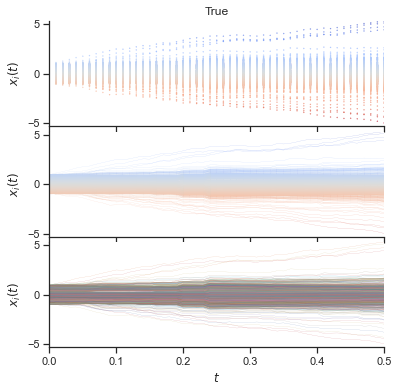

In [10]:
## Save/Load

Given the same parameters, a network can be restored without explicitly calling `run_network`. 

A simulation is saved using `ec.save(only_last=True)`. If `only_last` is `False`, the entire duration of the simulation is saved.

If a simulation exists for the network parameters, `ec.load()` restores the saved states and returns `True` (returns `False` otherwise).

filename = ec.save()
new_ec = EchoChamber(N, m, K, alpha)
new_ec.set_activities(activity_distribution, gamma, epsilon)
new_ec.set_social_interactions(beta, r, lazy=True) # note only the `r` is the important parameter
new_ec.set_dynamics()
loaded = new_ec.load(dt, T)
if not loaded:
    print("run network")
    new_ec.run_network(dt, T)
else:
    print("results loaded")

In [ ]:
# Figure 1

> The convenient `Simulation.run_params` static method is used.

# General params

N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
r=0.5 # probability of mutual interaction
dt=0.01

# Specific params for different dynamics
param_set={
    "neutral": dict(K=3,alpha=0.05,beta=2),
    "radical": dict(K=3,alpha=3,beta=0),
    "polar": dict(K=3,alpha=3,beta=3)
    }

In [11]:
## Neutral opinion (not shown)

Low controversialness

- $K = 3$
- $\alpha = 0.05$
- $\beta = 2$

ec_neutral = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['neutral'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, plot_opinion=True,
                                   cache="all")


DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=3, alpha=3, beta=0, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=True)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
DEBUG:echo chamber:trying to hit cache for C:\dev\opinion_dynamics\.cache\2116557791988040464.h5
echochamber=EchoChamber(N=1000,m=10,K=3,alpha=3,seed=1337) negpowerlaw(2.1, 0.01, 1) p_conn(beta=0) adj_mat(r=0.5)
INFO:echo chamber:done running echochamber
C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  encoding=encoding,
DEBUG:echo chamber:saved to C:\dev\opinion_dynamics\.cache\2116557791988040464.

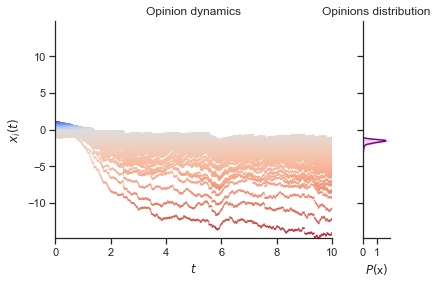

In [13]:
## Polarisation of opinions (1a)

Strong social interactions ($K$), controversial issue ($\alpha$), and greater chance of connecting with people with similar opinions ($\beta$)

- $K = 3$
- $\alpha = 3$
- $\beta = 3$


ec_polar = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['polar'],
                                 activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                 dt=dt, T=T, plot_opinion=True,
                                 cache="all")


## Radicalisation of opinions (1b)

Uniform connection probabilities

- $K = 3$
- $\alpha = 3$
- $\beta = 0$

In [ ]:
ec_radical = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['radical'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, plot_opinion=True,
                                   cache="all")


*for moderate $\beta$, a polarised network may turn radical.*

In [ ]:
T=20
ec_polar_radical = Simulation.run_params(EchoChamber, N=N, m=m,
                                         K=3, alpha=3, beta=0.6,
                                         activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                         dt=dt, T=T, plot_opinion=False,
                                         cache="all")
vis = VisEchoChamber(ec_polar_radical)
fig, axs = plt.subplots(2, 2, sharex='row', sharey=False)
gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, :]:
    ax.remove()
axbig = fig.add_subplot(gs[0, :])
fig.subplots_adjust(hspace=0.3)
vis.show_opinions(color_code='line', subsample=2, lw=1, ax=axbig)
vis.show_opinions_snapshot(t=5.0, ax=axs[1,0], kde_kws=dict(bw=0.1, shade=True), title=f"5")
vis.show_opinions_snapshot(ax=axs[1,-1], kde_kws=dict(shade=True), title=f"{T}")

In [ ]:
## Activity vs Opinion (1c)
Polarised param set
- $r = 0.65$

> to reproduce the density in the papers, $10^3$ "opinion states" need to be plotted, with each opinion state consisting of 1000 agents' opinions.

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

# parameters
N=1000
m=10
T=5
activity_distribution=negpowerlaw
epsilon=1e-2
gamma=2.1
dt=0.01
r=0.65

# how many simulations to run
try:
    from google.colab import drive
    num_states = 1000
except ModuleNotFoundError:
    num_states = 10
# where to save the file
file_name = ".cache/activity_vs_opinion.h5"

# helper array
agent_indices = np.arange(N, dtype=int)

# the efficient HDF format is used for saving and loading DataFrames.
with pd.HDFStore(file_name) as hdf:
    # get keys from the store to know how many simulations have already been saved
    states = hdf.keys()
    states_completed = len(states)
    # we start iterating from states_completed as the `seed` parameter uses `i`
    for i in tqdm(range(states_completed, num_states)):
        ec = Simulation.run_params(EchoChamber,N=N, m=m, **param_set['polar'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T, lazy=True, 
                                   cache=False, # don't cache time portion
                                   seed=i)
        # create dataframe for this iteration
        df = pd.DataFrame({"activity": ec.activities,
                           "opinion": ec.opinions
                          })
        # save to disk for use later
        hdf.append(f"d{i}", df)


# return to previous logging (more or less - we change root level)
logging.getLogger().setLevel(logging_level)

# collect all data into a dataframe
with pd.HDFStore(file_name) as hdf:
    df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])

# plot everything
# (very good idea to rasterize for saving)
fig, ax, cbar = show_activity_vs_opinion(df_ao.opinion.values, df_ao.activity.values,
                                         bins=N, norm=LogNorm(vmin=1/N),
                                         cbar_kws=dict(cax=True),
                                         s=0.1, rasterized=True)
ax.set_ylim(0, 0.5)
sns.despine()

# clear up some ram
del df_ao


In [ ]:
## Nearest Neighbour (1d)

In [ ]:
levels=10
g = vis.show_nearest_neighbour(bw=0.5, color=sns.cubehelix_palette(levels, reverse=True)[levels//2],
                               cmap=sns.cubehelix_palette(levels, reverse=True, as_cmap=True), levels=levels,
                               shade_lowest=True)
# adjust limits based on xaxis
from scipy import stats
x_data, y_data = g.ax_marg_x.get_lines()[0].get_data()
s = stats.describe(y_data)
low_bound = np.max(s.mean-s.variance, 0)
mask = (low_bound < y_data)
lim = x_data[mask][0]*1.5, x_data[mask][-1]*1.5
g.ax_joint.set_xlim(*lim)
# keep it 'square' (xlim == ylim)
g.ax_joint.set_ylim(*lim)

In [ ]:
## Generate figure 1

In [ ]:
from opdynamics.utils.plot_utils import move_cbar_label_to_title
with sns.plotting_context("paper"):
    # create figure and grid
    fig = plt.figure(figsize=(3.375, 2.618), dpi=200)
    gs = gridspec.GridSpec(nrows=2, ncols=2, wspace=1.1, hspace=0.9,
                           left=0.18, right=0.97, bottom=0.15,
                           height_ratios=[1,1.618])
    gs_trace_1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,0],
                                                  width_ratios=[1, 0.15],
                                                  wspace=0.1)
    gs_trace_2 = gridspec.GridSpecFromSubplotSpec(1, 2,  subplot_spec=gs[0,1],
                                                  width_ratios=[1, 0.15],
                                                  wspace=0.1)
    gs_activity = gridspec.GridSpecFromSubplotSpec(1, 2,  subplot_spec=gs[1,0],
                                                  width_ratios=[1, 0.1],
                                                  wspace=0.1)
    gs_nn = gridspec.GridSpecFromSubplotSpec(2, 2,  subplot_spec=gs[1,1],
                                             width_ratios=[1, 0.1], height_ratios=[0.1, 1],
                                             wspace=0.1, hspace=0.1)
    # create axes
    ax_trace_1 = fig.add_subplot(gs_trace_1[0])
    ax_dist_1 = fig.add_subplot(gs_trace_1[1], sharey=ax_trace_1)
    ax_trace_2 = fig.add_subplot(gs_trace_2[0])
    ax_dist_2 = fig.add_subplot(gs_trace_2[1], sharey=ax_trace_2)
    ax_activity = fig.add_subplot(gs_activity[0])
    ax_activity_cax = fig.add_subplot(gs_activity[1])
    ax_joint = fig.add_subplot(gs_nn[1,0])
    ax_marg_x = fig.add_subplot(gs_nn[0,0], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gs_nn[1,1], sharey=ax_joint)

    # Make the grid look nice
    sns.despine(fig)
    sns.despine(ax=ax_dist_1, left=False, bottom=True)
    sns.despine(ax=ax_dist_2, left=False, bottom=True)
    ax_dist_1.tick_params(labelleft=False, bottom=False, labelbottom=False)
    ax_dist_2.tick_params(labelleft=False, bottom=False, labelbottom=False)
    sns.despine(ax=ax_marg_x, left=True)
    sns.despine(ax=ax_marg_y, bottom=True)

    # polarised opinions trace
    vis = VisEchoChamber(ec_polar)
    vis.show_opinions(ax=ax_trace_1, color_code='line', subsample=10, lw=0.5, title="Polarised", rasterized=True)
    vis.show_opinions_snapshot(ax=ax_dist_1, kde_kws=dict(shade=False, bw=0.15), vertical=True, title=False)

    # radicalised opinions trace
    vis_radical = VisEchoChamber(ec_radical)
    vis_radical.show_opinions(ax=ax_trace_2, color_code='line', subsample=2, lw=1, title="Radicalised", rasterized=True)
    vis_radical.show_opinions_snapshot(ax=ax_dist_2, kde_kws=dict(shade=False, bw=0.15), vertical=True, title=False)

    # activity vs opinion
    file_name = ".cache/activity_vs_opinion.h5"
    with pd.HDFStore(file_name) as hdf:
        df_ao = pd.concat([hdf.get(key) for key in hdf.keys()])
    _,_,cbar = show_activity_vs_opinion(df_ao.opinion.values, df_ao.activity.values,
                                        ax=ax_activity,
                                        bins=N, norm=LogNorm(vmin=10/N),
                                        cmap='Spectral_r',
                                        cbar_kws=dict(cax=ax_activity_cax),
                                        s=0.01, rasterized=True, title=False)
    cbar.outline.set_visible(False)
    del df_ao

    # nearest neighbour
    show_jointplot(ec_polar.opinions, ec_polar.get_nearest_neighbours(),
                   ax=(ax_joint, ax_marg_x, ax_marg_y))

    # cleaning
    ax_trace_1.set_ylim(-5, 5)
    ax_trace_2.set_ylim(-5, 5)
    ax_trace_1.set_xticks([0,5,10])
    ax_trace_2.set_xticks([0,5,10])
    ax_dist_1.set_ylabel("")
    ax_dist_2.set_ylabel("")
    ax_dist_1.set_xlabel("")
    ax_dist_2.set_xlabel("")
    ax_dist_1.set_xlim(0, 0.7)
    ax_dist_2.set_xlim(0, 1.4)
    ax_activity.set_ylim(0, 0.5)
    ax_activity.set_xlim(-10, 10)
    move_cbar_label_to_title(ax_activity_cax)

    ax_joint.set_xlim(-5, 5)
    ax_joint.set_ylim(-5, 5)
    ax_joint.set_xlabel(OPINION_SYMBOL)
    ax_joint.set_ylabel(MEAN_NEAREST_NEIGHBOUR)

    for letter, _ax in zip(string.ascii_lowercase, [ax_trace_1,ax_trace_2, ax_activity, ax_marg_x]):
        _ax.annotate(f"({letter})", xy=(0, 1), xycoords="axes fraction",
                        xytext=(-27, 5), textcoords="offset points",
                        va="bottom", ha="right")
    # reduce space between axes labels and axes
    for _ax in flatten(fig.axes):
        _ax.yaxis.labelpad=0
        _ax.xaxis.labelpad=0
    fig.savefig("output/fig1.pdf")


In [ ]:
# NoisyEchoChamber

Add noise to the system

$\dot{x}_i= -x_i + K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha x_j)  + D [\rm nudge]$


 Symbol      | Keyword      | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|--------------|----------------------------------|----------------------------------------------------------|---------------------
 $D$         | ``D``        |``NoisyEchoChamber(EchoChamber)`` | Strength of noise/nudge                                         | $>=0$


## Open system (external noise)

$\dot{x}_i = K \cdot \sum_{j=1} A_{ij}(t) \cdot \tanh{(\alpha \cdot x_j)} + D \cdot \xi (t)$

 Symbol        | Variable | Keyword      | Class (inherits from)             | Meaning
---------------|----------|--------------|-----------------------------------|---------------
 $\xi(t)$      | -        | -            | ``OpenChamber(NoisyEchoChamber)`` | [Wiener process](https://en.wikipedia.org/wiki/Wiener_process)
 $\dot{\xi}$   | -        | -            | ``OpenChamber(NoisyEchoChamber)`` | Derivative $\mathcal{N}(0,\sqrt{dt})$


#@title Nudge strength ($D$)

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=5,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
D_range = [0, 0.01, 0.1, 0.5, 1, 10]
nec_arr = Simulation.run_product({'D':{'range':D_range}}, plot_opinion=True, **kwargs)
fig = plt.gcf()
fig.subplots_adjust(hspace=-0.5)
for ax in fig.axes:
    ax.set_facecolor("None")
    sns.despine(ax=ax, bottom=True, left=True)
    ax.tick_params(bottom=False, left=False, labelleft=False)
# fig.savefig("output/noise.pdf")
logging.getLogger().setLevel(logging_level)

#@title Check `dt`

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=1,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.001,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
product_vars = {
    'D': {
        'range': D_range,
    },
    'dt': {
        'range': np.arange(0.001, 0.01+0.001, 0.001)
        }
    }
Simulation.run_product(product_vars,
                       plot_opinion=True, title="dt",
                       label_precision=3, **kwargs)
fig = plt.gcf()
fig.savefig("output/dt.pdf")
logging.getLogger().setLevel(logging_level)

In [ ]:
#@title α, β

kwargs = dict(N=1000,
              m=10,
              T=10,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )

D_range = np.round(np.arange(0.0, 1.1, 0.1), 1)

parameters = {
    'D': {
        'range': D_range,
    },
    'beta':  {
        'range': [0, 1, 2, 3],
        'title': "$\\beta$",
    },
    'alpha': {
        'range': [0.001, 1, 2, 3], 
        'title': "$\\alpha$",
    },
}
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

df = Simulation.run_product(parameters, **kwargs)

logging.getLogger().setLevel(logging_level)

with sns.plotting_context("talk"):
    max_range = max([other['range'] for other in parameters.values()], key=len)
    fig, ax = plt.subplots(len(parameters),len(max_range), sharey=True, sharex=True, squeeze=False)
    fig.subplots_adjust(hspace=0.8)
    for i, (key, other) in enumerate(parameters.items()):
        show_noise_panel(df, key,
                         kde_kwargs=dict(bw=0.1, cut=2),
                         ax=ax[i])
        for _ax in ax[i]:
            _ax.set_title(f"{other['title']}={_ax.get_title()}")
            _ax.set_xlabel("")
            _ax.set(xlim=(-5,5), ylim=(0, 1))

    sns.despine(fig=fig)
    for _ax in ax[-1]:
        _ax.set_xlabel(math_fix(f"${OPINION_SYMBOL}$"))
    fig.savefig(f"output/{list(parameters.keys())}_grid.pdf")


In [ ]:
### Delayed noise

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              activity_distribution = negpowerlaw,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=3,
              beta=3,
              alpha=3,
              r=0.65,
              cls=OpenChamber
             )
D=0.5

noise_start = 10.
noise_length = 10.
recovery = 10.
num = 1
interval = 0
nec = Simulation.run_periodic_noise(noise_start, noise_length, recovery, interval=interval, num=num, 
                                    **kwargs,
                                    D=D, plot_opinion=True)
# fig = plt.gcf()
# fig.savefig("output/delayed_noise.pdf")
logging.getLogger().setLevel(logging_level)


In [ ]:
## Internal noise

### Dynamic connections

 Symbol      | Keyword      | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|--------------|----------------------------------|----------------------------------------------------------|---------------------
 $P(-\beta)$ | ``p_opp``    |``ConnChamber(EchoChamber)``      | Probability of interacting with an agent of opposing opinion    | $[0,1]$


In [ ]:
#@title Dynamic connections { run: "auto", vertical-output: true }

# polar opinions
N = 1000
m = 10  # number of other agents to interact with
alpha = 3  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
epsilon = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 3  # power law decay of connection probability
r = 0.5 # probability of a mutual interaction
activity_distribution = negpowerlaw
dt = 0.01
T = 10

p_opp = 0. #@param {type:"slider", min:0, max:1, step:0.05}

cc = ConnChamber(N, m, K, alpha)
cc.set_activities(activity_distribution, gamma, epsilon)
cc.set_social_interactions(beta, r, lazy=True, p_opp=p_opp)
cc.set_dynamics()
cc.run_network(dt, T, method='Euler')

vis = VisEchoChamber(cc)
fig, ax = plt.subplots(2, 2, gridspec_kw=dict(width_ratios=[1,0.1]))
vis.show_opinions(ax=ax[0,0])
fig.subplots_adjust(wspace=0.1, hspace=0.5)
vis.show_opinions_snapshot(ax=ax[0,1], vertical=True, kde_kws=dict(bw=0.1))
vis.show_adjacency_matrix("mesh", sort=True,
                                  cmap=sns.cubehelix_palette(light=1, as_cmap=True),
                                  cbar_kws=dict(pad=0.05, cax=ax[1,1]),
                                  ax=ax[1,0]
                                  )
move_cbar_label_to_title(ax[1,1])
for _ax in ax[0,:]:
    _ax.set_ylim(-5,5)
sns.despine()
sns.despine(ax=ax[0,1], left=True)
ax[0,1].set_ylabel("")
ax[0,1].set_yticks([])
fig.suptitle(f"p_opp={p_opp}")
fig.set_facecolor('w')


### Contrastive noise

Noise comes from exposing each agent to a random other agent, $x_k$, independent of $\beta$.

Either
1. Contrast own opinion with another
$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D (\tanh(\alpha_2 (x_i - x_k)))$
1. Show another agent's opinion
$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D (\tanh(\alpha_2 (x_k)))$


 Symbol        | Keyword      | Class (inherits from)                  | Meaning
---------------|--------------|----------------------------------------|---------------
 $x_k$         | ``k_steps``  | ``ConstrastChamber(NoisyEchoChamber)`` | Another agent chosen every $k$ time steps.
 $\alpha_2$    | ``alpha_2``  | ``ConstrastChamber(NoisyEchoChamber)`` | Scaling of agent's opinion (or difference of opinions)



#### Params vs noise

logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
kwargs = dict(N=1000,
              m=10,
              T=10,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=2,
              beta=1,
              alpha=3,
              r=0.65,
              k_steps=10,
              cls=ContrastChamber
             )

D_range = np.round(np.arange(0.0, 0.5, 0.05), 3)

parameters = {
    'D':{
        'range': D_range,
        'title': 'D',
    },
    'k_steps':{
        'range':[1, 100],
        'title':'k',
    },
    'alpha_2':{
        'range':[0.01, 0.1, 1, 10],
        'title':'$\alpha_2$',
    },
}
# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
noise_start = 0
            
df = Simulation.run_product(parameters,
                            noise_start=noise_start,
                            **kwargs)
logging.getLogger().setLevel(logging_level)

In [ ]:
grid_kwargs = dict(sharex=False, sharey=False, margin_titles=True, legend_out=True)
kde_kwargs = dict(bw=0.01)
g = show_opinion_grid(df, ['alpha_2','D','k_steps'], grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.add_legend(fontsize='large')

In [ ]:
g = show_opinion_grid(df, [x for x in parameters.keys() if x != "D"],
                    grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.map(sns.scatterplot, "opinion", "D", color='k', alpha=0.5, ec='None', s=1)

In [ ]:
## SampleChamber

The Central Limit Theorem states...

> Sample means are normally distributed.

> The mean of sample means approximates the true mean of the population.

In [ ]:
#title Set up polarised opinions { display-mode: "form" }

N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
r=0.5 # probability of mutual interaction
dt=0.01
K=3
alpha=3
beta=3

ec_polar = Simulation.run_params(EchoChamber, N=N, m=m,
                                 K=K, alpha=alpha, beta=beta,
                                 activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                 dt=dt, T=T, plot_opinion=True, cache="all")

In [ ]:
#title Check sample size and number of samples { run: "auto", display-mode: "form" }

sample_size = 30 #@param {type:"slider", min:1, max:1000, step:1}
num_samples = 1000 #@param {type:"slider", min:1, max:1000, step:1}

fig, ax = plt.subplots()

sample_means = ec_polar.get_sample_means(sample_size, num_samples)
mu = np.mean(sample_means)

sns.distplot(sample_means)

ax.annotate(f"$\mu' = {mu:.4f}$", xy=(mu, ax.get_ylim()[1]), xytext=(0, 5), textcoords="offset points",
                  ha='left',va='bottom', fontsize='x-small',
                  arrowprops=dict(arrowstyle='-|>'))
true_mu = np.mean(ec_polar.opinions)
ax.annotate(f"$\mu = {true_mu:.4f}$", xy=(true_mu, ax.get_ylim()[1]), xytext=(0, 5), textcoords="offset points",
                  ha='left',va='top', fontsize='x-small',
                  arrowprops=dict(arrowstyle='-|>'))
ax.set_xlabel(f"$\overline{{X}}_n$\n[$n$ = {sample_size}]")
ax.set_ylabel(f"$P(\overline{{X}}_n)$\n[# samples = {num_samples}]")


Add a "population opinion" term that captures the Lindeberg–Lévy Central Limit Theorem.


$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D \cdot \sqrt {n}\left({\bar{X}}_{n}-\mu \right)$

where $X$ is a random sample and $\bar{X}_{n}$ is the sample mean for $n$ random samples.

According to CLT, the means of random samples are normally distributed.

By substracting the true (or accurate estimate of the ) mean, $\mu$, and scaling by sample size ($\sqrt{n}$),
the normal distribution is centered on $0$.

$\sqrt {n}\left({\bar{X}}_{n}-\mu \right) \rightarrow \mathcal{N}\left(0,\sigma^{2}\right)$

 Symbol      | Keyword          | Class (inherits from)            | Meaning                                                         | Range ($\mathbb{R}$)
-------------|------------------|----------------------------------|----------------------------------------------------------|---------------------
 $n$         | ``sample_size``  |``SampleChamber(NoisyEchoChamber)``      | Number of opinions to sample from all agents    | $[0,N]$


#@title SampleChamber playground { vertical-output: true }

logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)

# polar opinions
N = 1000 #@param {type:"integer"}
m = 10 #@param {type:"integer"}
α = 3 #@param {type:"slider", min:0, max:5, step:0.5}
K = 3 #@param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01 #@param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1 #@param {type:"slider", min:0, max:3, step:0.1}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}
r = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
activity_distribution = negpowerlaw
dt = 0.01
T = 5 #@param {type:"slider", min:0, max:10, step:1}
# Nudge arguments
D = 3 #@param {type:"slider", min:0, max:20, step:0.5}
sample_size = 10 #@param {type:"slider", min:1, max:100, step:1}
sample_method = "basic" #@param ["basic", "outer_sigmoid", "inner_sigmoid", "subsample"]

integration_method = "Euler" #@param ["Euler", "RK45"]
iterations = 1 #@param {type:"slider", min:1, max:20, step:1}

fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[1,0.1]), sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.5)
palette = sns.color_palette("husl", n_colors=iterations)

seeds = np.geomspace(1, 100000, num=20, dtype=int)

for i in range(iterations):
    sc = Simulation.run_params(cls=SampleChamber, N=N, m=m, K=K, alpha=α, beta=β,
                               activity=activity_distribution, gamma=Υ, epsilon=ε,
                               r=r, dt=dt, T=T, D=D,
                               sample_size=sample_size, sample_method=sample_method,
                               method=integration_method,
                               plot_opinion=False,
                               seed=seeds[i], cache="all")

    vis = VisEchoChamber(sc)
    vis.show_opinions(color_code='line', ax=ax[0])
    vis.show_opinions_snapshot(ax=ax[1], vertical=True,
                            kde_kws=dict(bw=0.1), color=palette[i])
ax[0].set_ylim(-5,5)

logging.getLogger().setLevel(logging_level)

In [ ]:
### Run parameter sweep

In [ ]:
logging_level = logging.getLogger().getEffectiveLevel()
eclogger.setLevel(logging.INFO)
logging.getLogger().setLevel(logging.INFO)

parameters = dict(
    N=1000,
    m=10,
    T=5.0,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    K=3,
    beta=3,
    alpha=3,
    r=0.5,
    cls=SampleChamber,
    method="Euler",
)

D_range = np.round(np.arange(0.0, 5.0001, 0.1), 3)

sample_size_range = np.arange(1, 50.0001, 1, dtype=int)

range_parameters = {
    "D": {"range": D_range, "title": "D"},
    "sample_size": {"range": sample_size_range, "title": "n"},
    "alpha": {"range": [1, 2, 3], "title": "α"},
    "beta": {"range": [1, 2, 3], "title": "β"},
    "K": {"range": [1, 2, 3], "title": "K"},
}

df = Simulation.run_product(
    range_parameters,
    noise_start=0,
    cache=True,
    cache_sim=True,
    parallel=True,
    **parameters
)
logging.getLogger().setLevel(logging_level)

In [ ]:
### Plot

grid_kwargs = dict(sharex=True, sharey=False,
                   margin_titles=True, legend_out=True)
kde_kwargs = dict(bw=0.01)

sub_df = df[
    (df["D"].isin([0.0, 1.0, 2.0, 3.0, 4.0, 5.0])) & (df["sample_size"].isin([1, 10]))
]

defaults = {
    'D': 'col',
    'sample_size': 'row',
    'alpha': 3,
    'K': 3,
    'beta': 3,
}
import ipywidgets as widgets
pickers = {}
for key in range_parameters:
  if key in sub_df.columns:
    unique = sub_df[key].unique()
    desc = range_parameters[key]['title'] if 'title' in range_parameters[key] else key
    pickers[key] = widgets.Dropdown(description=desc,
                                    options=list(unique)+['col', 'row', 'hue'], value=defaults[key])

def f(**kwargs):
    try:
        out.clear_output()
    except:
        pass
    columns = []
    for key, value in kwargs.items():
        if value in ['col', 'row', 'hue']:
            if value == 'col':
                columns.insert(0, key)
            elif value == 'row':
                columns.insert(1, key)
            else:
                columns.append(key)
            continue
    default_kwargs = {k: v for k, v in kwargs.items() if k not in columns}
    default_df = df_multi_mask(sub_df, default_kwargs)
    print("plotting")
    g = show_opinion_grid(default_df, columns,
                          grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
    g.add_legend()
out = widgets.interactive_output(f, pickers)
widgets.VBox([widgets.HBox(list(pickers.values())), out])

In [ ]:
#title Figure 2

# polar opinions
α = 3 #@param {type:"slider", min:0, max:5, step:0.5}
K = 3 #@param {type:"slider", min:0, max:5, step:0.5}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}

assert α in range_parameters['alpha']['range']
assert β in range_parameters['beta']['range']
assert K in range_parameters['K']['range']

defaults = {
    'alpha': α,
    'K': K,
    'beta': β,
}
sub_D_range = [0, 1.0, 3.0, 5.0]
col_wrap = len(sub_D_range)//2
sub_sample_range = [1, 10, 40]
print("masking")
sub_df = df_multi_mask(
    df[
        (df["D"].isin(sub_D_range))
        & (df["sample_size"].isin(sub_sample_range))
    ],
    defaults,
).to_pandas_df().rename({'sample_size':'n', 'opinion':OPINION_SYMBOL}, axis=1)
print("plotting")
with sns.plotting_context("paper"):
    plt.rcParams['figure.dpi'] = 200
    sns.set_palette(sns.color_palette("colorblind", len(sub_sample_range)))
    n_cols = len(sub_D_range)
    n_rows = 1
    width = 4/n_cols
    aspect = 1
    height = width/aspect
    grid_kwargs = dict(sharex=True, sharey=True,
                    margin_titles=False, legend_out=True,
                    height=height, aspect=aspect,
                    )
    kde_kwargs = dict(lw=0.5, bw=0.1)
    sub_df['D'] = sub_df['D'].astype(int)
    g = sns.FacetGrid(sub_df, col="D", col_wrap=col_wrap, hue="n", **grid_kwargs)

    kde_kwargs.setdefault("shade", True)
    kde_kwargs.setdefault("shade_lowest", False)
    g.map(sns.kdeplot, OPINION_SYMBOL, **kde_kwargs)
    g.set(xlim=(-5,5), ylim=(0, g.axes[0].get_ylim()[1]*1.1))
    for ax in g.axes[-col_wrap:]:
        ax.set_xlabel(f'{OPINION_SYMBOL}')
    for ax in g.axes[0:-1:col_wrap]:
        ax.set_ylabel(f'P({OPINION_SYMBOL})')
    g.add_legend(fontsize='small')
    for line in g._legend.get_lines():
        line.set_linewidth(1.0)
    for f, f_ax in enumerate(g.axes):
    # f_ax = g.axes[1]
        y_data_max = max([max(l.get_ydata()) for l in f_ax.get_lines()])*0.96
        y_max = f_ax.get_ylim()[1]*1.05
        color='grey'
        f_ax.annotate(PEAK_DISTANCE,
                    xy=(0, y_data_max),
                    xytext=(0, y_max),
                    arrowprops=dict(arrowstyle=f'-[,widthB={max(0.35-0.1*f**1.5,0)}',
                                    color='k', alpha=0.7, lw=0.5),
                      alpha=0.8,
                    fontsize='x-small',
                    va='center',
                    ha='center')
    print("saving")
    g.savefig("output/dist_n.pdf")

In [ ]:
#@title 2D KDE plot

defaults = {
    'alpha': α,
    'K': K,
    'beta': β,
}
sub_D_range = np.round(np.arange(0.0, 5.0001, 0.1), 3)
print("masking")
sub_df = df_multi_mask(
    df[
        (df["D"].isin(sub_D_range))
        & (df["sample_size"]==1)
    ],
    defaults,
).to_pandas_df().rename({'opinion':OPINION_SYMBOL}, axis=1)
print("plotting")
with sns.plotting_context("paper"):
    fig, axs = plt.subplots(ncols=2, figsize=(3.375, 2), dpi=200, gridspec_kw=dict(width_ratios=[1, 0.1]))
    ax = axs[0]
    cbar_ax = axs[1]
    sns.kdeplot(sub_df[OPINION_SYMBOL], sub_df["D"],
                # bw=0.1,
                shade=True, shade_lowest=True, cmap='Spectral_r',
                cbar=True,cbar_ax=cbar_ax,
                ax=ax)
    ax.set_xlim(-4, 4)
    # ax.set_ylim(0, 5)
    cbar_ax.set_title(f"P(x, D)")
    fig.tight_layout()
    fig.savefig("output/x_v_d.pdf",tight=True)

In [ ]:
g = show_opinion_grid(sub_df,
                      [x for x in parameters.keys() if x != "D"],
                      grid_kwargs=grid_kwargs, kde_kwargs=kde_kwargs)
g.map(sns.scatterplot, "opinion", "D", color='k', alpha=0.5, ec='None', s=1)


In [ ]:
#@title Figure 3

with sns.plotting_context('paper'):
    zs = plot_surfaces(df, "D", "sample_size", parameters, range_parameters,
                       rasterized=True, # False for a LARGE pdf
                       )
    fig = plt.gcf()
    fig.axes[0].set_xlim(0,5)
    fig.axes[0].set_ylim(0,50)
    sns.despine(offset=0, trim=False)
    plt.gcf().savefig(os.path.join("output","d_sample_surface.pdf"))


In [ ]:
#@title Figure 4

# zs = plot_surface_product(df, "D", "sample_size", parameters, range_parameters)

range_parameters['sample_size']['range'] = list(range(1, 21))
zs_20 = calc_distribution_differences(df, "D", "sample_size", range_parameters,
                                   N=parameters["N"])

from matplotlib.cbook import flatten
n_cols = len(range_parameters['alpha']['range'])
n_rows = len(range_parameters['K']['range'])
width = 3./n_cols
aspect = 1.2
height = width/aspect

with sns.plotting_context("paper"):
    g = sns.relplot(
        x="D",
        y=PEAK_DISTANCE_MEAN,
        hue='β',
        col='α',
        row='K',
        data=zs_20.rename({'beta':'β', 'alpha':'α'}, axis=1),
        height=height,
        aspect=aspect,
        # palette=sns.color_palette('colorblind', 3),
        facet_kws=dict(margin_titles=True, legend_out=True),
        # ec="None", alpha=0.8,
        linewidth=0.1,
        s=5,
        legend='full',
    )
    g.set(xscale='log', xlim=(0.1, 6))
    for ax in flatten(g.axes):
        ax.set_ylabel(ax.get_ylabel(), rotation=0, ha='right')
    g.savefig("output/D_v_peak.pdf")
    ;

In [ ]:
with sns.plotting_context("paper"):
    g = sns.relplot(
        x="D",
        y=PEAK_DISTANCE_VAR,
        hue='β',
        col='α',
        row='K',
        data=zs_20.rename({'beta':'β', 'alpha':'α'}, axis=1),
        height=height,
        aspect=aspect,
        # palette=sns.color_palette('colorblind', 3),
        facet_kws=dict(margin_titles=True, legend_out=True),
        # ec="None", alpha=0.8,
        linewidth=0.1,
        s=5,
        legend='full',
    )
    g.set(xscale='log', xlim=(0.1, 6))
    for ax in flatten(g.axes):
        ax.set_ylabel(ax.get_ylabel(), rotation=0, ha='right')
    g.savefig("output/D_v_peak_var.pdf")
    ;


In [ ]:
# Delayed internal noise

# suppress logging for clean progressbar
logging_level = logging.getLogger().getEffectiveLevel()
logging.getLogger().setLevel(logging.WARNING)
from opdynamics.utils.cache import get_cache_dir, set_cache_dir
old_dir, new_dir = set_cache_dir(os.path.join("/content",".cache","delayed_noise"))

noise_start = 5.
noise_length = 5.
recovery = 5.
num = 1
interval = 0
import opdynamics.networks.echochamber as ec

kwargs = dict(N=1000,
              m=10,
              activity_distribution = negpowerlaw,
              epsilon=1e-2,
              gamma=2.1,
              dt=0.01,
              K=3,
              beta=3,
              alpha=3,
              r=0.5,
              update_conn=True,
              cls=ec.SampleChamber,
              method='RK45',
              D=5,
              sample_size=30,
              sample_method="basic",
              noise_start=noise_start,
              noise_length=noise_length,
              recovery=recovery,
              interval=interval,
              num=num,
             )
with sns.plotting_context("paper"):
    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = (3.375, 3)
    nec_list = Simulation.run_product(range_parameters={'D':{'range':[1,3,5]},
                                               'sample_size':{'range':[1,30,50]},
                                               'sample_method': {'range':['basic','subsample']},
                                               },
                                      cache="all",
                                      cache_sim=False,
                                      parallel=True,
                                      plot_opinion=True,
                                      **kwargs
                                      )

old_dir, new_dir = set_cache_dir(old_dir)
logging.getLogger().setLevel(logging_level)



### Compare sample methods

In [ ]:
from opdynamics.dynamics.opinions import clt_methods


# polar opinions
N = 1000 #@param {type:"integer"}
m = 10 #@param {type:"integer"}
α = 3 #@param {type:"slider", min:0, max:5, step:0.5}
K = 3 #@param {type:"slider", min:0, max:5, step:0.5}
ε = 0.01 #@param {type:"slider", min:0.005, max:0.05, step:0.005}
Υ = 2.1 #@param {type:"slider", min:0, max:3, step:0.1}
β = 3 #@param {type:"slider", min:0, max:5, step:0.5}
r = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}
activity_distribution = negpowerlaw
dt = 0.01
T = 5 #@param {type:"slider", min:0, max:10, step:1}
# Nudge arguments
D = 1 #@param {type:"slider", min:0, max:20, step:0.5}
sample_size = 1 #@param {type:"slider", min:1, max:100, step:1}
seed_idx = 10 #@param {type:"slider", min:0, max:20, step:1}
integration_method = "RK45" #@param ["Euler", "RK45"]

clt_method_names = [k for k in clt_methods.keys() if k is not None]

# custom sample methods
from opdynamics.metrics.opinions import sample_means

def custom_sample_n1v1000(ec, y: np.ndarray, n: int, num_samples: int):
    ec._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=ec.rn) -
        sample_means(y, 1000, num_samples=num_samples, rng=ec.rn)
    )
def custom_sample_n1v100(ec, y: np.ndarray, n: int, num_samples: int):
    ec._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=ec.rn) -
        sample_means(y, 100, num_samples=num_samples, rng=ec.rn)
    )
def custom_sample_n1vmean(ec, y: np.ndarray, n: int, num_samples: int):
    ec._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=ec.rn) -
        np.mean(y)
    )
def custom_sample_n1v1(ec, y: np.ndarray, n: int, num_samples: int):
    ec._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=ec.rn) -
        sample_means(y, 1, num_samples=num_samples, rng=ec.rn)
    )
def custom_sample_n1v10(ec, y: np.ndarray, n: int, num_samples: int):
    ec._sample_means = (
        sample_means(y, 1, num_samples=num_samples, rng=ec.rn) -
        sample_means(y, 10, num_samples=num_samples, rng=ec.rn)
    )
def custom_sample_n1v0(ec, y: np.ndarray, n: int, num_samples: int):
    ec._sample_means = sample_means(y, 1, num_samples=num_samples, rng=ec.rn)
def custom_sample_n0v1(ec, y: np.ndarray, n: int, num_samples: int):
    ec._sample_means = -sample_means(y, 1, num_samples=num_samples, rng=ec.rn)
def custom_sample_n0(ec, y: np.ndarray, n: int, num_samples: int):
    ec._sample_means = 0

clt_method_names += [
                   custom_sample_n1v1000,
                   custom_sample_n1v100,
                   custom_sample_n1v10,
                   custom_sample_n1v1,
                   custom_sample_n1vmean,
                   custom_sample_n1v0,
                   custom_sample_n0v1,
                   custom_sample_n0]

fig, ax = plt.subplots(len(clt_method_names), 2, gridspec_kw=dict(width_ratios=[1,0.1]),
                       sharey='row',
                       sharex='col',
                       dpi=250)
fig.subplots_adjust(wspace=0.1, hspace=0.5)
palette = sns.color_palette("husl", n_colors=len(clt_method_names))

seeds = np.geomspace(1, 100000, num=20, dtype=int)

for i, sample_method in enumerate(clt_method_names):
    sc = Simulation.run_params(cls=SampleChamber, N=N, m=m, K=K, alpha=α, beta=β,
                               activity=activity_distribution, gamma=Υ, epsilon=ε,
                               r=r, dt=dt, T=T,
                               D=D, sample_size=sample_size, sample_method=sample_method,
                               method=integration_method,
                               plot_opinion=False,
                               seed=seeds[seed_idx],
                               cache="all")

    vis = VisEchoChamber(sc)
    vis.show_opinions(color_code='line', ax=ax[i, 0],
                      title=sample_method if type(sample_method) is str else sample_method.__name__)
    vis.show_opinions_snapshot(ax=ax[i, 1], vertical=True,
                            kde_kws=dict(bw=0.1), color=palette[i], title=None)
    if i<len(clt_method_names):
        ax[i,0].set_xlabel("")
        ax[i,1].set_xlabel("")
    ax[i,0].set_ylim(-5,5)

# Other plot types

## $K-\alpha$ phase space

- $K \in [0,4]$
- $\alpha \in [0,4]$

with
- $beta = 0.5$
- $r = 0.5$


In [ ]:
import os
import gc
eclogger.setLevel(logging.DEBUG)

beta = 0.5
r = 0.5

# how many simulations to run
num_states = 8
start = 0
stop = 4
K_range = np.round(np.linspace(start,stop,num_states), 2)
alpha_range = np.round(np.linspace(start,stop,num_states), 2)


# where to save the file
file_name = ".cache/K-alpha-phase.h5"

# the efficient HDF format is used for saving and loading DataFrames.
if os.path.exists(file_name):
    df = pd.read_hdf(file_name)
else:
    df = pd.DataFrame(index=K_range, columns=alpha_range, dtype=float)
    for K,alpha in tqdm(list(itertools.product(K_range,alpha_range))):
        ec = Simulation.run_params(EchoChamber,N=N, m=m, K=K, alpha=alpha, beta=beta,
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma, r=r,
                                   dt=dt, T=T,
                                   lazy=True,
                                   cache=False, # don't cache full time of sim
                                   plot_opinion=False)
        t, mu = ec.get_mean_opinion(-1)
        df.loc[K, alpha] = mu
        # clear some memory
        del ec
        gc.collect()
    df.to_hdf(file_name, key='df')

In [ ]:
show_K_alpha_phase(df)
fig = plt.gcf()
fig.savefig("output/k-alpha-phase.pdf")

## Agent opinions at $t$

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
fig.subplots_adjust(hspace=0.3)
vis.show_agent_opinions(direction=True, sort=True, ax=ax[0])
vis.show_opinions_snapshot(ax=ax[1], kde_kws=dict(shade=True))
ax[1].set_xticklabels(ax[1].get_xticks())
sns.despine()

In [ ]:
fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[10,1]))
fig.subplots_adjust(wspace=0.1)
vis.show_opinions(ax=ax[0], title="Polarised")
vis.show_opinions_snapshot(ax=ax[1], kde_kws=dict(shade=False, bw=0.15), vertical=True)
sns.despine()
sns.despine(ax=ax[1], left=True)
ax[1].set_ylabel("")
ax[1].tick_params(axis='y', left=False, labelleft=False)

In [ ]:
fig, ax = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[10,1]))
fig.subplots_adjust(wspace=0.1)
vis.show_opinions(ax=ax[0], title="Polarised")
vis.show_opinions_snapshot(ax=ax[1], kde_kws=dict(shade=False, bw=0.15), vertical=True)
sns.despine()
sns.despine(ax=ax[1], left=True)
ax[1].set_ylabel("")
ax[1].tick_params(axis='y', left=False, labelleft=False)